This notebook calculates the direct damages to rail assets including climate change

In [2]:
# Imports
import configparser
from pathlib import Path
import pathlib
from direct_damages import damagescanner_rail_track as ds
import pandas as pd
import geopandas as gpd
import datetime
from ci_adapt_utilities import *
import pickle
import os
from matplotlib import pyplot as plt

In [3]:
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

p = Path('..')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'collected_flood_runs'

In [4]:
# Read vulnerability and maximum damage data from Nirandjan, S., et al. (2024)
curve_types = {'rail': ['F8.1']}
infra_curves, maxdams = ds.read_vul_maxdam(data_path, hazard_type, infra_type)
max_damage_tables = pd.read_excel(data_path / vulnerability_data / 'Table_D3_Costs_V1.0.0.xlsx',sheet_name='Cost_Database',index_col=[0])
print(f'Found matching infrastructure curves for: {infra_type}')

Found matching infrastructure curves for: rail


In [5]:
# Read hazard data (Rauthe M, et al. (2020): Climate impact analysis of the federal transport system in the context of floods: Final report of the key topic flood risks (SP-103) in topic area 1 of the BMVI expert network. 136 pages. DOI: 10.5675/ExpNRM2020.2020.04)
#n_drive_dpath=Path(r'N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps')
#hazard_data_list = ds.read_hazard_data(n_drive_dpath, hazard_type, country=country_name, subfolders=None)#hazard_data_subfolders)
local_haz_path=data_path/r'Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries'
hazard_data_list = ds.read_hazard_data(local_haz_path, hazard_type, country=country_name, subfolders=None)#hazard_data_subfolders)

print(f'Found {len(hazard_data_list)} hazard maps.')

Found 12 hazard maps.


In [6]:
# Read exposure data (OSM, OpenStreetMap contributors (2024) / osm-flex)
assets_path = data_path / asset_data
assets = gpd.read_file(assets_path)
assets = gpd.GeoDataFrame(assets).set_crs(4326).to_crs(3857)
assets = assets.loc[assets.geometry.geom_type == 'LineString']
assets = assets.rename(columns={'railway' : 'asset'})
assets = assets[assets['asset']=='rail']


# # Drop bridges and tunnels
# assets = assets.loc[~(assets['bridge'].isin(['yes']))]
# assets = assets.loc[~(assets['tunnel'].isin(['yes']))]

assets = assets[assets['railway:traffic_mode']!='"passenger"']
assets = assets.reset_index(drop=True)

# Add buffer to assets to do area intersect and create dictionaries for quicker lookup
buffered_assets = ds.buffer_assets(assets)
geom_dict = assets['geometry'].to_dict()
type_dict = assets['asset'].to_dict()

print(f"{len(assets)} assets loaded.")

##TODO: move all data preprocessing to different notebook (ie pre-prepared network)

2822 assets loaded.


In [10]:
# Calculate direct damage by asset (Koks. E.E. (2022). DamageScanner: Python tool for natural hazard damage assessments. Zenodo. http://doi.org/10.5281/zenodo.2551015)
# currently data with 3 baseline return periods: H=RP10, M=RP100, L=RP200
# TODO: for DEXX_RP, return period should be input or taken from dictionary/file names
# TODO: verify cost of damage and adaptation regarding double rail or single rail, divide /2 if double rail? 
collect_output={}
for i, single_footprint in enumerate(hazard_data_list):
    hazard_name = single_footprint.parts[-1].split('.')[0]
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f'{timestamp} - Reading hazard map {i+1} of {len(hazard_data_list)}: {hazard_name}')

    try:
        collect_output[hazard_name] = process_hazard_data(single_footprint, hazard_type, assets, interim_data_path, infra_curves, max_damage_tables, curve_types, infra_type, type_dict, geom_dict)
    except Exception as e:
        print(f'Error occurred in {hazard_name}: {str(e)}')
        continue

# save the data to pickle files
collect_output_path = f'{interim_data_path}/sample_collected_run.pkl'
if len(collect_output)>0:
    with open(collect_output_path, 'wb') as f:
        pickle.dump(collect_output, f)
else: print('No output collected')

2024-07-19 17:06:46 - Reading hazard map 1 of 12: flood_DERP_RW_H_4326_2080411370
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_H_4326_2080411370.geojson
2024-07-19 17:06:49 - Coarse overlay of hazard map with assets...


100%|██████████| 19/19 [00:16<00:00,  1.17it/s]


2024-07-19 17:07:56 - Reading hazard map 2 of 12: flood_DERP_RW_H_4326_2080416200
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_H_4326_2080416200.geojson
2024-07-19 17:08:08 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


2024-07-19 17:11:07 - Reading hazard map 3 of 12: flood_DERP_RW_H_4326_2080416210
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_H_4326_2080416210.geojson
2024-07-19 17:11:15 - Coarse overlay of hazard map with assets...


100%|██████████| 24/24 [01:01<00:00,  2.55s/it]


2024-07-19 17:15:47 - Reading hazard map 4 of 12: flood_DERP_RW_H_4326_2080418880
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_H_4326_2080418880.geojson
2024-07-19 17:15:52 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:00<00:00,  8.93it/s]


2024-07-19 17:16:39 - Reading hazard map 5 of 12: flood_DERP_RW_L_4326_2080411370
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_L_4326_2080411370.geojson
2024-07-19 17:16:42 - Coarse overlay of hazard map with assets...


100%|██████████| 98/98 [02:18<00:00,  1.42s/it]


2024-07-19 17:19:30 - Reading hazard map 6 of 12: flood_DERP_RW_L_4326_2080416200
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_L_4326_2080416200.geojson
2024-07-19 17:19:48 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


2024-07-19 17:24:46 - Reading hazard map 7 of 12: flood_DERP_RW_L_4326_2080416210
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_L_4326_2080416210.geojson
2024-07-19 17:24:56 - Coarse overlay of hazard map with assets...


100%|██████████| 155/155 [06:57<00:00,  2.69s/it]


2024-07-19 17:34:20 - Reading hazard map 8 of 12: flood_DERP_RW_L_4326_2080418880
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_L_4326_2080418880.geojson
2024-07-19 17:34:29 - Coarse overlay of hazard map with assets...


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


2024-07-19 17:36:24 - Reading hazard map 9 of 12: flood_DERP_RW_M_4326_2080411370
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_M_4326_2080411370.geojson
2024-07-19 17:36:28 - Coarse overlay of hazard map with assets...


100%|██████████| 43/43 [01:15<00:00,  1.75s/it]


2024-07-19 17:38:53 - Reading hazard map 10 of 12: flood_DERP_RW_M_4326_2080416200
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_M_4326_2080416200.geojson
2024-07-19 17:39:09 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


2024-07-21 16:54:57 - Reading hazard map 11 of 12: flood_DERP_RW_M_4326_2080416210
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_M_4326_2080416210.geojson
2024-07-21 16:55:13 - Coarse overlay of hazard map with assets...


100%|██████████| 94/94 [04:06<00:00,  2.62s/it]


2024-07-21 17:11:43 - Reading hazard map 12 of 12: flood_DERP_RW_M_4326_2080418880
Flood map path: C:\Data\Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries\flood_DERP_RW_M_4326_2080418880.geojson
2024-07-21 17:11:51 - Coarse overlay of hazard map with assets...


100%|██████████| 9/9 [00:00<00:00, 10.00it/s]


In [11]:
# Save the data to csv files
sample_output_name=f'sample_collected_run_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
pd.DataFrame.from_dict(collect_output).to_csv(interim_data_path / sample_output_name)

In [7]:
# if collected_output variable doesnt exist, load from pickle file
if 'collect_output' not in locals():
    collect_output_path = f'{interim_data_path}/sample_collected_run.pkl'
    with open(collect_output_path, 'rb') as f:
        collect_output = pickle.load(f)

In [8]:
# Calculate the expected annual damages (EAD)
summed_output = {}

# Iterate over the items in the collect_output dictionary
for hazard_map, asset_dict in collect_output.items():
    #TODO: Exclude bridges and tunnels from computaion here
    # If the hazard_map and hazard_curve combination is not already in the summed_output dictionary, add it with the sum of the current lower and upper bounds
    if hazard_map not in summed_output:
        summed_output[hazard_map] = (sum(value[0] for value in asset_dict.values()), sum(value[1] for value in asset_dict.values()))
    # If the hazard_map and hazard_curve combination is already in the summed_output dictionary, add the sum of the current lower and upper bounds to the existing ones
    else:
        summed_output[hazard_map][0] += sum(value[0] for value in asset_dict.values())
        summed_output[hazard_map][1] += sum(value[1] for value in asset_dict.values())

# Initialize a new dictionary to hold the aggregated values
aggregated_output = {'_H_': [0, 0], '_M_': [0, 0], '_L_': [0, 0]}

# Iterate over the items in the summed_output dictionary and group into return periods
for hazard_map, (lower_bound, upper_bound) in summed_output.items():
    # determine the category of the hazard map
    if '_H_' in hazard_map: 
        category = '_H_'
    elif '_M_' in hazard_map: 
        category = '_M_'
    else: # '_L_' in hazard_map
        category = '_L_' 
        
    # Add the lower and upper bounds to the appropriate category
    aggregated_output[category][0] += lower_bound
    aggregated_output[category][1] += upper_bound

# Create the DataFrame from the new dictionary
aggregated_df = pd.DataFrame.from_dict(aggregated_output, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
aggregated_df


,Total Damage Lower Bound,Total Damage Upper Bound
_H_,6.524741e+06,1.985026e+07
_M_,4.256054e+07,9.409703e+07
_L_,3.033289e+08,7.434283e+08


Baseline expected annual damages: 5,079,561.16 to 12,427,352.57 EUR
Expected annual damages without adaptation by year 100: 22,561,832.38 to 53,206,237.65 EUR


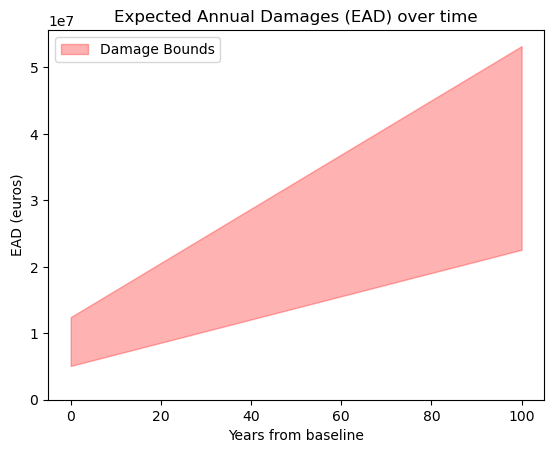

In [9]:
# Define the baseline return periods 
"""
Return period definitions for Rhineland Palatinate (DERP) based on the report by Rauthe M, et al. (2020):
_H_=10-25y 
_M_=100y
_L_=200y
"""
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}

# Add climate change: calculate the dynamic return periods based on flat increase factors. 
# This value has been catchment-specific with frequency increasing in some regions and decreasing in others. 
# It is reasonable that in the future, the frequency will continue to change differently by catchment.

increase_factor = {
    '_H_': (1.2+9.0)/2,
    '_M_': (1.2+9.0)/2,
    '_L_': (1.2+9.0)/2 #average of the range (1.2 to 9.0) based on change since 1900
}

num_years = 100
return_periods = calculate_dynamic_return_periods(return_period_dict, num_years, increase_factor)

# Define dictionary to relate return periods to regions, in this case Rheinland Palatinate is used
return_period_dict = {}
return_period_dict['DERP'] = return_periods #TODO: make generic for other regions

# Add the return period column to aggregated_df and sort by return period
aggregated_df['Return Period'] = [return_period_dict['DERP'][index] for index in aggregated_df.index]
aggregated_df = aggregated_df.sort_values('Return Period', ascending=True)

# Calculate the probability of each return period 
aggregated_df['Probability'] = [[1 / x for x in i] for i in aggregated_df['Return Period']]
probabilities = aggregated_df['Probability']
dmgs = []

# Calculate the expected annual damages for each time step using trapezoidal rule for integration
for ts in range(len(probabilities.iloc[0])):    
    dmgs_l = []
    dmgs_u = []

    for rp in range(len(probabilities)-1):
        d_rp= probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
        trap_damage_l = 0.5 * (aggregated_df['Total Damage Lower Bound'].iloc[rp] + aggregated_df['Total Damage Lower Bound'].iloc[rp + 1])
        trap_damage_u = 0.5 * (aggregated_df['Total Damage Upper Bound'].iloc[rp] + aggregated_df['Total Damage Upper Bound'].iloc[rp + 1])
        dmgs_l.append(d_rp * trap_damage_l)
        dmgs_u.append(d_rp * trap_damage_u)
    
    # Add the portion of damages corresponding to the tails of the distribution
    # Assumption - considers the damage for return periods higher than the highest return period the same as that of the highest return period
    d0_rp = probabilities.iloc[-1][ts]
    damage_l0 = max(aggregated_df['Total Damage Lower Bound'])
    damage_u0 = max(aggregated_df['Total Damage Upper Bound'])
    dmgs_l.append(d0_rp * damage_l0)
    dmgs_u.append(d0_rp * damage_u0)

    # Assumption - considers that no assets are damaged at a return period of 4 years or lower
    d_end_rp = (1/4)-probabilities.iloc[0][ts]
    damage_l_end = 0.5 * min(aggregated_df['Total Damage Lower Bound'])
    damage_u_end = 0.5 * min(aggregated_df['Total Damage Upper Bound'])
    dmgs_l.append(d_end_rp * damage_l_end)
    dmgs_u.append(d_end_rp * damage_u_end)

    dmgs.append((sum(dmgs_l), sum(dmgs_u)))

ead_by_ts = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])

print(f'Baseline expected annual damages: {dmgs[0][0]:,.2f} to {dmgs[0][1]:,.2f} EUR')
print(f'Expected annual damages without adaptation by year {num_years}: {dmgs[-1][0]:,.2f} to {dmgs[-1][1]:,.2f} EUR')

ead_by_ts_plot(ead_by_ts)

In [10]:
# Calculate the expected annual damages (EAD)
summed_output = {}
# Iterate over the items in the collect_output dictionary
for hazard_map, asset_dict in collect_output.items():
    # If the hazard_map and hazard_curve combination is not already in the summed_output dictionary, add it with the sum of the current lower and upper bounds
    if hazard_map not in summed_output:
        summed_output[hazard_map] = (sum(value[0] for value in asset_dict.values()), sum(value[1] for value in asset_dict.values()))
    # If the hazard_map and hazard_curve combination is already in the summed_output dictionary, add the sum of the current lower and upper bounds to the existing ones
    else:
        summed_output[hazard_map][0] += sum(value[0] for value in asset_dict.values())
        summed_output[hazard_map][1] += sum(value[1] for value in asset_dict.values())

summed_output

{'flood_DERP_RW_H_4326_2080411370': (3706407.631635442, 13355041.119988918),
 'flood_DERP_RW_H_4326_2080416200': (371968.07039315416, 588934.6375495153),
 'flood_DERP_RW_H_4326_2080416210': (2223105.2839304516, 5680770.2349705845),
 'flood_DERP_RW_H_4326_2080418880': (223259.52726981675, 225518.36110925552),
 'flood_DERP_RW_L_4326_2080411370': (74902682.93510352, 217676348.97581798),
 'flood_DERP_RW_L_4326_2080416200': (1289100.7997082649, 1656499.9830870815),
 'flood_DERP_RW_L_4326_2080416210': (224060936.75219318, 515944055.0506774),
 'flood_DERP_RW_L_4326_2080418880': (3076185.3474778305, 8151367.111712774),
 'flood_DERP_RW_M_4326_2080411370': (21973749.266109113, 30350436.928871177),
 'flood_DERP_RW_M_4326_2080416200': (515796.36355988134, 743828.7434325991),
 'flood_DERP_RW_M_4326_2080416210': (19651387.27429098, 62271152.881619245),
 'flood_DERP_RW_M_4326_2080418880': (419603.9421775297, 731609.2061460909)}

In [11]:
files = [file for file in os.listdir(interim_data_path) if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
# summed_output  is a dicitonary of with keys as the hazard map names and values as a tuple of the lower and upper bounds of the total damage
# example: {'flood_DERP_RW_H_4326_2080411370': (3706407.631635442, 13355041.119988918),

# for a list of all the basins in the region, retrieve the upper and lower damage bounds for each basin and skip if the basin is not a key in the summed_output dictionary

# create a dictionary of dictionaries with the basin number as the level 1 key, the category (ie "H") as the level 2 key and the upper and lower bounds as the values
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in summed_output.keys():
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = summed_output[key]


aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue
    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_period_dict['DERP'][index] for index in aggregated_df_by_basin[basin].index]
    aggregated_df_by_basin[basin] = aggregated_df_by_basin[basin].sort_values('Return Period', ascending=True)
    aggregated_df_by_basin[basin]['Probability'] = [[1 / x for x in i] for i in aggregated_df_by_basin[basin]['Return Period']]
    probabilities = aggregated_df_by_basin[basin]['Probability']
    dmgs = []

    for ts in range(len(probabilities.iloc[0])):    
        dmgs_l = []
        dmgs_u = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
            trap_damage_l = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp + 1])
            trap_damage_u = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp + 1])
            dmgs_l.append(d_rp * trap_damage_l)
            dmgs_u.append(d_rp * trap_damage_u)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities.iloc[-1][ts]
        damage_l0 = max(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u0 = max(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d0_rp * damage_l0)
        dmgs_u.append(d0_rp * damage_u0)

        d_end_rp = (1/4)-probabilities.iloc[0][ts]
        damage_l_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d_end_rp * damage_l_end)
        dmgs_u.append(d_end_rp * damage_u_end)

        dmgs.append((sum(dmgs_l), sum(dmgs_u)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
    
 


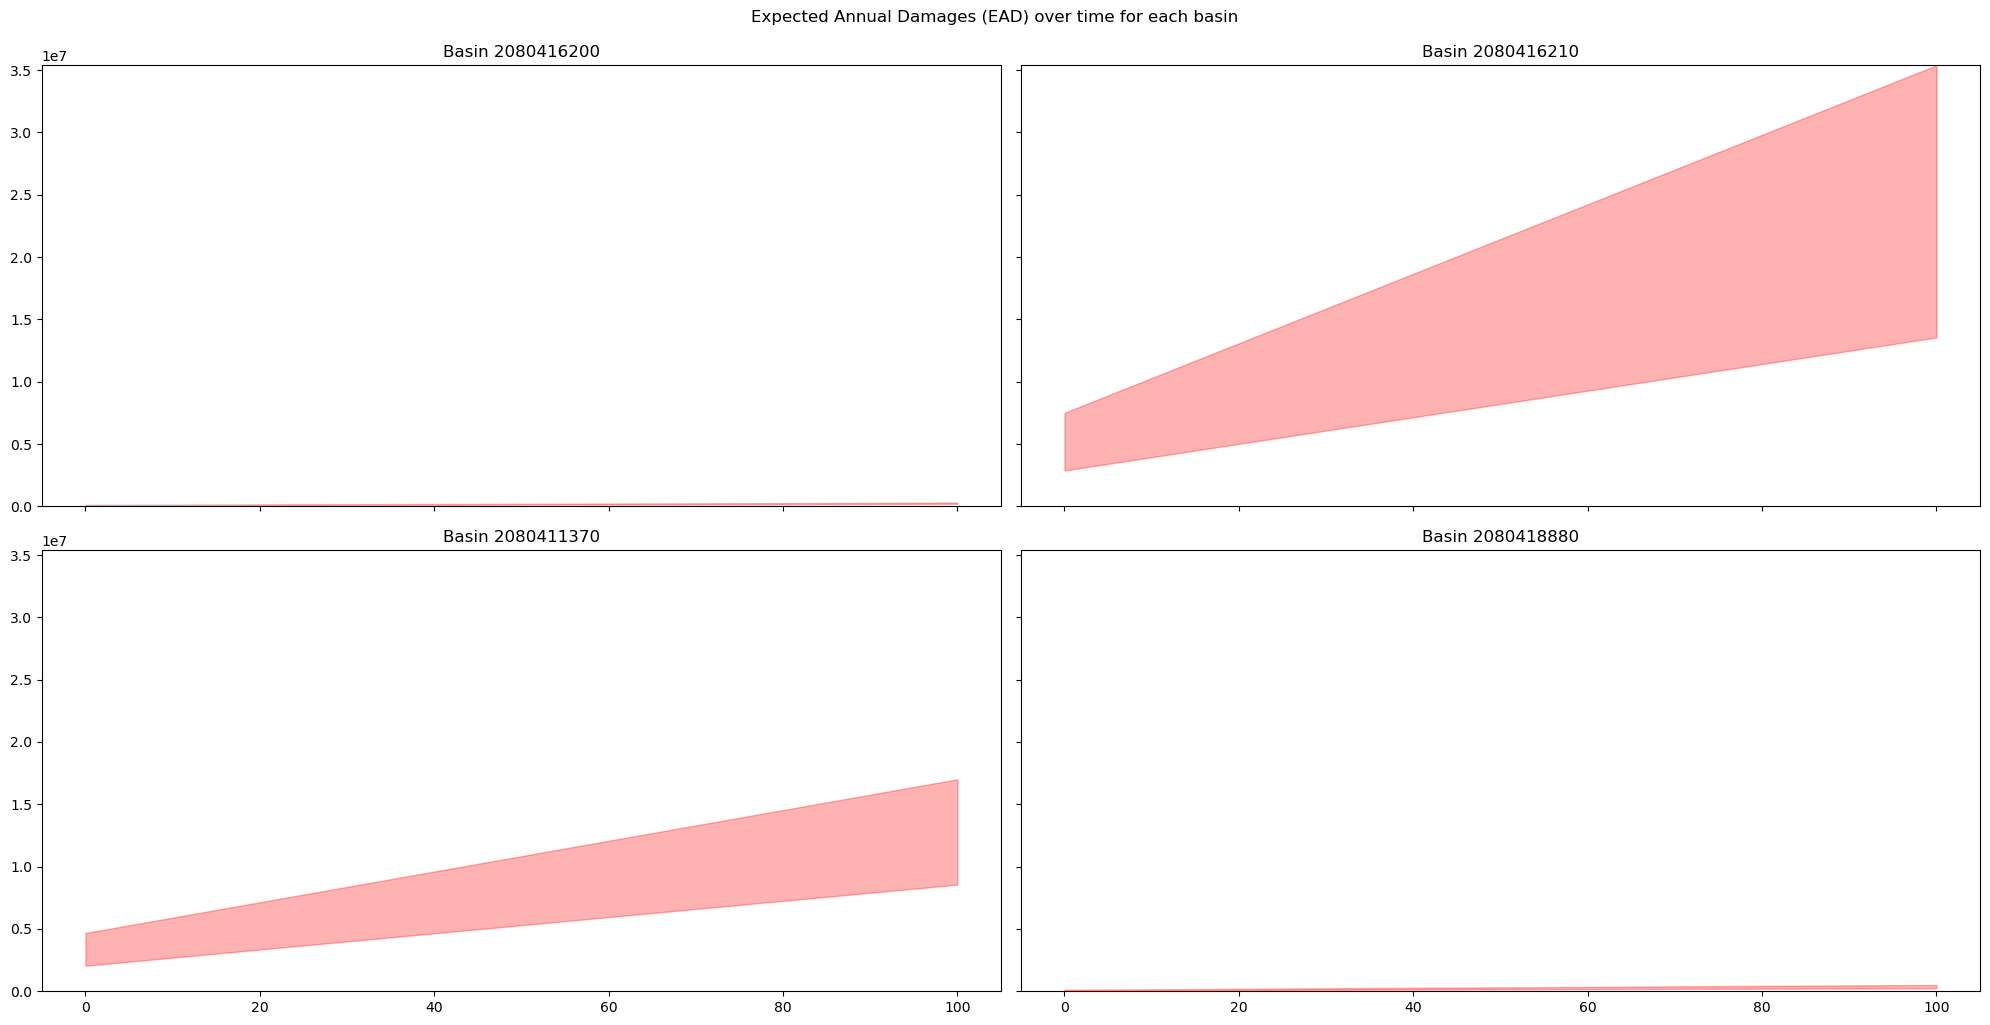

In [12]:
# Calculate the number of rows and columns based on the number of basins
num_basins = len(ead_by_ts_by_basin)
num_cols = int(np.ceil(np.sqrt(num_basins)))
num_rows = int(np.ceil(num_basins / num_cols))

# Create subplots with shared x-axis, the calculated number of rows and columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows), sharex=True, sharey=True)

# Flatten axs array for easy iteration
axs = axs.flatten()

max_value = max([ead_by_ts_by_basin[basin]['Total Damage Upper Bound'].max() for basin in ead_by_ts_by_basin.keys()])

for i, basin in enumerate(ead_by_ts_by_basin.keys()):
    axs[i].fill_between(ead_by_ts_by_basin[basin].index, ead_by_ts_by_basin[basin]['Total Damage Lower Bound'], ead_by_ts_by_basin[basin]['Total Damage Upper Bound'], alpha=0.3, color='red')
    axs[i].set_title(f'Basin {basin}')
    axs[i].set_ylim(0, max_value)  # Set y-axis lower limit to 0 and upper limit to max_value

# Hide any unused axes
for j in range(num_basins, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout()
plt.suptitle('Expected Annual Damages (EAD) over time for each basin', y=1.02)
plt.show()


In [14]:
assets.iloc[12]

osm_id                                                            7990468
asset                                                                rail
name                                                                 None
gauge                                                                1435
electrified                                                  contact_line
voltage                                                             15000
bridge                                                               None
maxspeed                                                              120
service                                                              None
tunnel                                                               None
other_tags              "frequency"=>"16.7","operator"=>"DB Netz AG","...
railway:traffic_mode                                              "mixed"
usage                                                              "main"
geometry                LINESTRING (81